In [1]:
import rubin_sim.maf as maf
import numpy as np

from rubin_scheduler.utils import (
    angular_separation,
    ddf_locations,
    ddf_locations_pre3_5,
    hpid2_ra_dec,
    sample_patch_on_sphere,
)
import healpy as hp
radius=2.5

In [2]:
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)


In [3]:
ddfs = {}
nside=512
nside_sne=128

ddfs_rough = ddf_locations()
for ddf in ddfs_rough:
    ddfs[ddf] = {"ra": ddfs_rough[ddf][0], "dec": ddfs_rough[ddf][1]}
# Combine the Euclid double-field into one - but with two ra/dec values
ddfs["EDFS"] = {
    "ra": [ddfs["EDFS_a"]["ra"], ddfs["EDFS_b"]["ra"]],
    "dec": [ddfs["EDFS_a"]["dec"], ddfs["EDFS_b"]["dec"]],
}
del ddfs["EDFS_a"]
del ddfs["EDFS_b"]
# Let's include an arbitrary point that should be in the WFD for comparison
ddfs["WFD"] = {"ra": 0, "dec": -20.0}

ra, dec = hpid2_ra_dec(nside, np.arange(hp.nside2npix(nside)))
ra_sne, dec_sne = hpid2_ra_dec(nside_sne, np.arange(hp.nside2npix(nside_sne)))

ddf_slicers = {}
ddf_slicers_sne = {}
for ddf in ddfs:
    # Define the healpixels to use for this DDF
    if np.size(ddfs[ddf]["ra"]) > 1:
        goods = []
        goods_sne = []
        for ddf_ra, ddf_dec in zip(ddfs[ddf]["ra"], ddfs[ddf]["dec"]):
            dist = angular_separation(ra, dec, ddf_ra, ddf_dec)
            goods.append(np.where(dist <= radius)[0])
            dist = angular_separation(ra_sne, dec_sne, ddf_ra, ddf_dec)
            goods_sne.append(np.where(dist <= radius)[0])
        good = np.unique(np.concatenate(goods))
        good_sne = np.unique(np.concatenate(goods_sne))
    else:
        dist = angular_separation(ra, dec, np.mean(ddfs[ddf]["ra"]), np.mean(ddfs[ddf]["dec"]))
        good = np.where(dist <= radius)[0]
        dist = angular_separation(ra_sne, dec_sne, np.mean(ddfs[ddf]["ra"]), np.mean(ddfs[ddf]["dec"]))
        good_sne = np.where(dist <= radius)[0]
        ddf_slicers_sne[ddf] = maf.HealpixSubsetSlicer(nside_sne, good_sne, use_cache=False)
        ddf_slicers[ddf] = maf.HealpixSubsetSlicer(nside, good, use_cache=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [4]:
ddfs

{'ELAISS1': {'ra': 9.45, 'dec': -44.025},
 'XMM_LSS': {'ra': 35.574999999999996, 'dec': -4.816666666666666},
 'ECDFS': {'ra': 52.979166666666664, 'dec': -28.116666666666667},
 'COSMOS': {'ra': 150.1083333333333, 'dec': 2.233611111111111},
 'EDFS': {'ra': [58.9, 63.6], 'dec': [-49.32, -47.6]},
 'WFD': {'ra': 0, 'dec': -20.0}}

In [5]:
bundle_list = []

ddf = 'XMM_LSS'
plotDict = {
            "visufunc": hp.gnomview,
            "rot": (np.mean(ddfs[ddf]["ra"]), np.mean(ddfs[ddf]["dec"]), 0),
            "xsize": 500,
        }
plotFuncs = [maf.HealpixSkyMap()]
metric = maf.metrics.SNNSNMetric(
    verbose=False,
    n_bef=4,
    n_aft=10,
    zmin=0.1,
    zmax=1.1,
    z_step=0.03,
    daymax_step=3,
    coadd_night=True,
    gamma_name="gamma_DDF.hdf5",
    # have to add field name here, to avoid reduceDict key collissions
    metric_name="DDF_hdf",
)
bundle_list.append(
    maf.MetricBundle(
        metric,
        ddf_slicers_sne[ddf],
        constraint="",
        #info_label=" ".join([fieldname, "all bands"]),
        plot_dict=plotDict,
        plot_funcs=plotFuncs,
        #summary_metrics=summary_stats,
        #display_dict=displayDict,
    )
)

metric = maf.metrics.SNNSNMetric(
    verbose=False,
    n_bef=4,
    n_aft=10,
    zmin=0.1,
    zmax=1.1,
    z_step=0.03,
    daymax_step=3,
    coadd_night=True,
    #gamma_name="gamma_DDF.hdf5",
    # have to add field name here, to avoid reduceDict key collissions
    metric_name="WFD_hdf",
)
bundle_list.append(
    maf.MetricBundle(
        metric,
        ddf_slicers_sne[ddf],
        constraint="",
        #info_label=" ".join([fieldname, "all bands"]),
        plot_dict=plotDict,
        plot_funcs=plotFuncs,
        #summary_metrics=summary_stats,
        #display_dict=displayDict,
    )
)



Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 63121 799 79
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 73508 799 92
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 88689 799 111
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 63121 799 79
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_-2.0_0.2_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 73508 799 92
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 g 20774 799 26


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 i 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 r 50337 799 63
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 y 78302 799 98
Loading  /Users/yoachim/rubin_sim_data/maf/SNe_data/LC_0.0_0.0_380.0_800.0_ebvofMW_0.0_vstack.hdf5 z 88689 799 111


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")


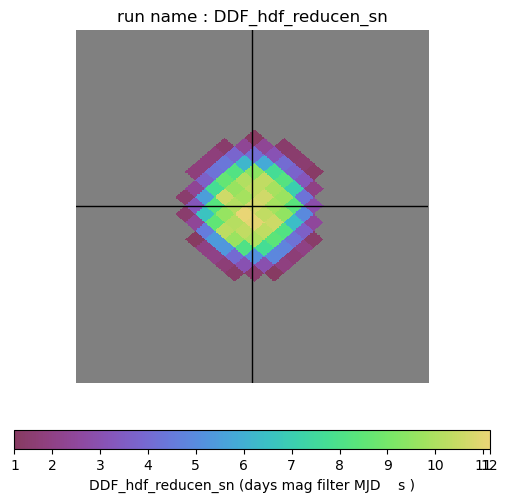

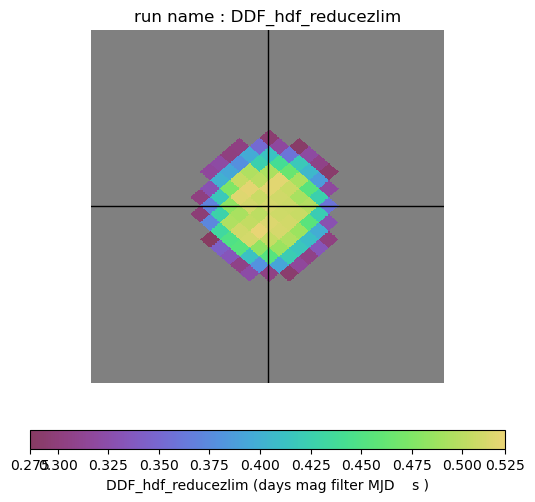

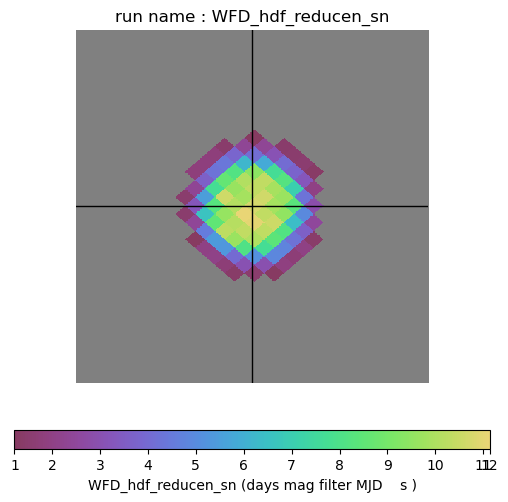

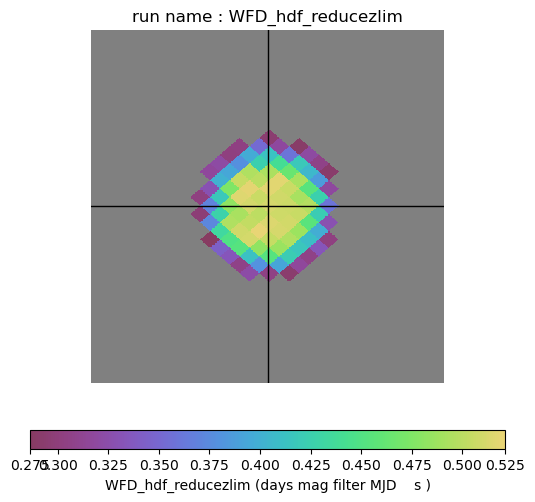

In [6]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, "early_draft_notoo_v3.5_10yrs.db", out_dir=out_dir, results_db=results_db)
#bg = maf.metricBundles.MetricBundleGroup(bd, "/Users/yoachim/runs34/baseline/baseline_v3.4_10yrs.db", out_dir=out_dir, results_db=results_db)

bg.run_all()
bg.plot_all(closefigs=False)

In [7]:
bundle_list[0].metric_values

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=nan,
            dtype=object)